# Thin film Lithium Niobate Electro-Optic Modulator using Tidy3D

In this example, we will simulate a thin-film lithium niobate electro-optic modulator based on the Pockels effect. The device is based on the work of `*Ying Li et al.*, “High-Performance Mach–Zehnder Modulator Based on Thin-Film Lithium Niobate with Low Voltage-Length Product,” *ACS Omega* 2023, 8 (10), 9644–9651.` DOI: [10.1021/acsomega.3c00310](https://pubs.acs.org/doi/10.1021/acsomega.3c00310).

We start by calculating the propagating modes of the TFLN waveguide and the coplanar (CPW) transmission line using [mode simulation](https://www.flexcompute.com/tidy3d/examples/notebooks/ModeSolver/).

Finally, we calculate the electro-optic overlap and predict the Vπ·L figure of merit.

You can check [here](https://docs.flexcompute.com/projects/photonforge/en/latest/examples/EO-MZM.html) the same model, along with the full chip layout integrated with a foundry PDK, using [Photonforge](https://www.flexcompute.com/photonforge/), our photonic design automation tool.

<img src="img/TFLN_EOM_Tidy3D.png" width=600 alt="Schematic of the grating coupler">

### Workflow Overview

[1.](#1) Define the thin-film lithium niobate waveguide geometry and solve for the optical TE mode using the [ModeSolver](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.mode.ModeSolver.html).

[2.](#2) Build the CPW transmission line in the same cross-section and compute the RF mode and its overlap with the optical waveguide.

[3.](#3) Normalize the RF field to 1 V across the electrodes, evaluate the electro-optic overlap, and estimate Vπ·L.

In [1]:
# Core simulation and plotting libraries
import numpy as np
import tidy3d as td

# RF utilities for impedance and port definitions
import tidy3d.rf as rf
from matplotlib import pyplot as plt
from tidy3d import web
from tidy3d.plugins.mode import ModeSolver

# Suppress verbose logs to keep the notebook output clear
td.config.logging_level = "ERROR"

## Optical Waveguide Geometry <a name="1"></a>

In [2]:
# Simulation parameters
eff_inf = 1e3  # Large extent to emulate semi-infinite regions

opt_wavelength = 1.55
freq_opt = td.C_0 / opt_wavelength

# Optical materials: SiO2 cladding and TFLN core
SiO2 = td.material_library["SiO2"]["Palik_Lossless"]
LiNbO3 = td.material_library["LiNbO3"]["Zelmon1997"](1)

# Ridge geometry parameters from the reference design
sidewall_angle = 17
core_width = 1.1  # w0
slab_thickness = 0.22  # h3
h3 = slab_thickness
core_thickness = 0.4 - slab_thickness
plane_size = 8
plane_limits = (-1.5, 1.9)
plane_height = 3.4


# Define waveguide structures
ridge = td.Structure(
    name="ridge",
    geometry=td.Box(
        center=(0.0, 0.0, -slab_thickness / 2), size=(eff_inf, eff_inf, slab_thickness)
    ),
    medium=LiNbO3,
)

core = td.Structure(
    geometry=td.PolySlab(
        sidewall_angle=sidewall_angle * np.pi / 180,
        reference_plane="top",
        slab_bounds=[0, core_thickness],
        vertices=[
            [-eff_inf, -core_width / 2],
            [eff_inf, -core_width / 2],
            [eff_inf, core_width / 2],
            [-eff_inf, core_width / 2],
        ],
    ),
    name="core",
    medium=LiNbO3,
)

# Grid specification
grid_spec = td.GridSpec.auto(min_steps_per_wvl=20, wavelength=opt_wavelength)

# Create optical simulation
sim_opt = td.Simulation(
    size=(10.0, plane_size, plane_height),
    run_time=1e-12,
    medium=SiO2,
    structures=[ridge, core],
    grid_spec=grid_spec,
)

### Creating the [ModeSolver](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.mode.ModeSolver.html) object and running the mode simulation

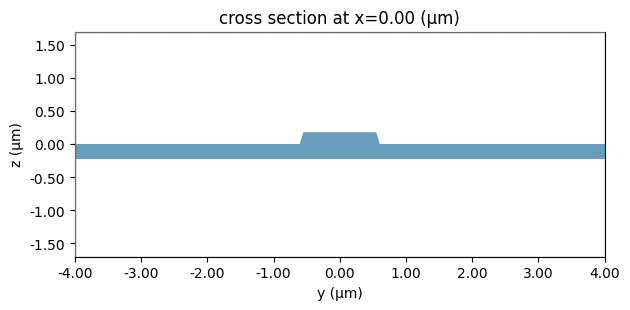

In [3]:
## Creating the ModeSolver

mode_spec = td.ModeSpec(num_modes=5, group_index_step=True)

plane_size = (0, sim_opt.bounding_box.size[1], sim_opt.bounding_box.size[2])
plane = sim_opt.bounding_box.updated_copy(size=plane_size)

mode_solver_opt = ModeSolver(simulation=sim_opt, freqs=[freq_opt], mode_spec=mode_spec, plane=plane)

_ = mode_solver_opt.plot()

plt.show()

In [4]:
mode_data_opt = web.run(mode_solver_opt, task_name="TFLN-opt_mode", folder_name="TFLN-VPI")

15:08:20 EST Created task 'TFLN-opt_mode' with resource_id                      
             'mo-8e2b4865-7943-4fee-93a0-ba812e41d7d9' and task_type            
             'MODE_SOLVER'.

             View task using web UI at                                          
             ]8;id=47456;https://tidy3d.simulation.cloud/workbench?taskId=mo-8e2b4865-7943-4fee-93a0-ba812e41d7d9\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=497240;https://tidy3d.simulation.cloud/workbench?taskId=mo-8e2b4865-7943-4fee-93a0-ba812e41d7d9\taskId]8;;\]8;id=47456;https://tidy3d.simulation.cloud/workbench?taskId=mo-8e2b4865-7943-4fee-93a0-ba812e41d7d9\=]8;;\]8;id=203229;https://tidy3d.simulation.cloud/workbench?taskId=mo-8e2b4865-7943-4fee-93a0-ba812e41d7d9\mo]8;;\]8;id=47456;https://tidy3d.simulation.cloud/workbench?taskId=mo-8e2b4865-7943-4fee-93a0-ba812e41d7d9\-8e2b4865-7943-]8;;\
             ]8;id=47456;https://tidy3d.simulation.cloud/workbench?taskId=mo-8e2b4865-7943-4fee-93a0-ba812e41d7d9\4fee-93a0-ba812e41d7d9']8;;\.

             Task folder: ]8;id=104750;https://tidy3d.simulation.cloud/folders/folder-3c92f54f-4ff3-4c2c-b81e-c653296dc2f1\'TFLN-VPI']8;;\.

Output()

15:08:30 EST Estimated FlexCredit cost: 0.005. Minimum cost depends on task     
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

15:08:31 EST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

15:09:31 EST starting up solver

             running solver

15:09:39 EST status = success

             View simulation result at                                          
             ]8;id=159810;https://tidy3d.simulation.cloud/workbench?taskId=mo-8e2b4865-7943-4fee-93a0-ba812e41d7d9\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=359495;https://tidy3d.simulation.cloud/workbench?taskId=mo-8e2b4865-7943-4fee-93a0-ba812e41d7d9\taskId]8;;\]8;id=159810;https://tidy3d.simulation.cloud/workbench?taskId=mo-8e2b4865-7943-4fee-93a0-ba812e41d7d9\=]8;;\]8;id=232727;https://tidy3d.simulation.cloud/workbench?taskId=mo-8e2b4865-7943-4fee-93a0-ba812e41d7d9\mo]8;;\]8;id=159810;https://tidy3d.simulation.cloud/workbench?taskId=mo-8e2b4865-7943-4fee-93a0-ba812e41d7d9\-8e2b4865-7943-]8;;\
             ]8;id=159810;https://tidy3d.simulation.cloud/workbench?taskId=mo-8e2b4865-7943-4fee-93a0-ba812e41d7d9\4fee-93a0-ba812e41d7d9']8;;\.

Output()

15:09:42 EST Loading simulation from simulation_data.hdf5

We can now visualize and inspect the optical modes. We are interested in the TE-like fundamental mode (with *mode_index == 0*), which has an effective index of 1.85 and a group index of 2.20. This information is very important to ensure velocity matching between the optical and RF modes, and hence optimize the electro-optical effect.

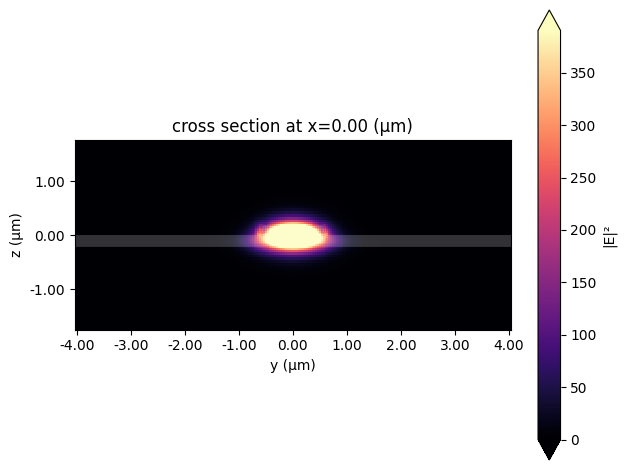

In [5]:
mode_solver_opt.plot_field("E", "abs^2", mode_index=0)
mode_data_opt.to_dataframe()

plt.show()

## RF CPW Transmission Line <a name="2"></a>

Next, we define the CPW geometry and again use [ModeSolver](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.mode.ModeSolver.html) to calculate the RF mode.

For more information on CPW mode calculation, one can refer to [this](https://www.flexcompute.com/tidy3d/examples/notebooks/CPWRFPhotonics1/) example.

In [6]:
# RF frequency range
rf_freqs = np.linspace(10e9, 90e9, 21)

# RF materials
si_rf = td.Medium(permittivity=11.7)
sio2_rf = td.Medium(permittivity=3.9)
air_rf = td.Medium()
tfln_rf = td.AnisotropicMedium(
    xx=td.Medium(permittivity=43), yy=td.Medium(permittivity=27.9), zz=td.Medium(permittivity=43)
)
metal = td.LossyMetalMedium(
    frequency_range=(100000000.0, 100000000000.0),
    conductivity=41,
    fit_param=td.SurfaceImpedanceFitterParam(
        max_num_poles=16,
    ),
)

Since we will sweep over many variables, it is convenient to create a function to return the CPW and optical waveguide geometries.

In [7]:
def get_structures(
    h4=4.7,
    h2=0.4,
    h1=1,
    cpw_thickness=1,  # CPW geometry parameters
    cpw_width=18,  # w1
    cpw_gap=5,  # g
    optical_waveguide_gap=25,
):  # G
    sio2_thickness = h1 + h3 + h4

    si_substrate = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-eff_inf, -eff_inf, -eff_inf), rmax=(eff_inf, eff_inf, -sio2_thickness / 2)
        ),
        medium=si_rf,
    )

    # Define substrate and layer structures
    sio2_slab = td.Structure(
        geometry=td.Box(center=(0, 0, 0), size=(eff_inf, eff_inf, sio2_thickness)), medium=sio2_rf
    )

    # Optical waveguide

    center_slab = sio2_slab.geometry.bounds[0][2] + h4 + slab_thickness / 2

    tfln_slab = td.Structure(
        geometry=td.Box(center=(0, 0, center_slab), size=(eff_inf, eff_inf, slab_thickness)),
        medium=tfln_rf,
    )

    # Calculate vertical offset to position waveguides at TFLN slab level
    delta_z = tfln_slab.geometry.center[2] - ridge.geometry.center[2]

    # Define conformal cladding for waveguides

    delta_z_conformal = sio2_slab.geometry.bounds[1][2]

    waveguide_conformal_cladding = td.PolySlab(
        sidewall_angle=sidewall_angle * np.pi / 180,
        reference_plane="top",
        slab_bounds=[delta_z_conformal, delta_z_conformal + core_thickness],
        vertices=[
            [-eff_inf, -core_width / 1.5],
            [eff_inf, -core_width / 1.5],
            [eff_inf, core_width / 1.5],
            [-eff_inf, core_width / 1.5],
        ],
    )

    # Define right waveguide positioned under CPW gap
    waveguide_r = [
        ridge.updated_copy(
            geometry=ridge.geometry.translated(
                x=0, y=optical_waveguide_gap / 2 + core_width / 2, z=delta_z
            ),
            name="ridge_r",
            medium=tfln_rf,
        ),
        core.updated_copy(
            geometry=core.geometry.translated(
                x=0, y=optical_waveguide_gap / 2 + core_width / 2, z=delta_z
            ),
            name="core_r",
            medium=tfln_rf,
        ),
        td.Structure(
            geometry=waveguide_conformal_cladding.translated(
                x=0, y=optical_waveguide_gap / 2 + core_width / 2, z=0
            ),
            medium=sio2_rf,
        ),
    ]

    # Define left waveguide positioned under CPW gap
    waveguide_l = [
        ridge.updated_copy(
            geometry=ridge.geometry.translated(
                x=0, y=-optical_waveguide_gap / 2 - core_width / 2, z=delta_z
            ),
            name="ridge_l",
            medium=tfln_rf,
        ),
        core.updated_copy(
            geometry=core.geometry.translated(
                x=0, y=-optical_waveguide_gap / 2 - core_width / 2, z=delta_z
            ),
            name="core_l",
            medium=tfln_rf,
        ),
        td.Structure(
            geometry=waveguide_conformal_cladding.translated(
                x=0, y=-optical_waveguide_gap / 2 - core_width / 2, z=0
            ),
            medium=sio2_rf,
        ),
    ]

    cpw_center_pos = sio2_slab.geometry.bounds[1][2] + cpw_thickness / 2

    # Define CPW transmission line structures
    cpw_left = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-eff_inf, -eff_inf, cpw_center_pos - cpw_thickness / 2),
            rmax=(eff_inf, -cpw_width / 2 - cpw_gap, cpw_center_pos + cpw_thickness / 2),
        ),
        medium=metal,
    )

    cpw_right = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-eff_inf, cpw_width / 2 + cpw_gap, cpw_center_pos - cpw_thickness / 2),
            rmax=(eff_inf, eff_inf, cpw_center_pos + cpw_thickness / 2),
        ),
        medium=metal,
    )

    cpw_center = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-eff_inf, -cpw_width / 2, cpw_center_pos - cpw_thickness / 2),
            rmax=(eff_inf, cpw_width / 2, cpw_center_pos + cpw_thickness / 2),
        ),
        medium=metal,
    )

    air_gap = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-eff_inf, -eff_inf, sio2_thickness / 2), rmax=(eff_inf, eff_inf, eff_inf)
        ),
        medium=air_rf,
    )

    return (
        [sio2_slab, si_substrate, air_gap, cpw_left, cpw_right, cpw_center, tfln_slab]
        + waveguide_l
        + waveguide_r
    )


structures = get_structures()

In [8]:
def get_sim(
    h4=4.7,  # top SiO2 cladding thickness (µm)
    h2=0.4,
    h1=1,  # lower layer thickness beneath the electrodes (µm)
    cpw_thickness=1,  # CPW geometry parameters (t)
    cpw_width=18,  # w1
    cpw_gap=5,
    optical_waveguide_gap=23 - core_width / 2,  # G
    refinement=10,
    resolution=30,
    fields=["Ex", "Ey", "Ez", "Hx", "Hy", "Hz"],
):  # g)
    structures = get_structures(
        h4, h2, h1, cpw_thickness, cpw_width, cpw_gap, optical_waveguide_gap
    )
    # Define layer refinement specification for enhanced mesh at CPW corners

    cpw_center = structures[5]
    cpw_left = structures[3]
    cpw_right = structures[4]
    tfln_slab = structures[6]

    lr_spec = td.LayerRefinementSpec.from_structures(
        structures=[cpw_center, cpw_left, cpw_right],
        min_steps_along_axis=5,
        corner_refinement=td.GridRefinement(dl=cpw_thickness / refinement, num_cells=5),
        refinement_inside_sim_only=False,
    )

    # Mesh override for waveguide region (fine mesh in z-direction)
    override_region = td.MeshOverrideStructure(
        geometry=td.Box(
            size=(eff_inf, eff_inf, slab_thickness + core_thickness),
            center=(0, 0, tfln_slab.geometry.center[2] + slab_thickness / 2),
        ),
        dl=(None, None, 0.05),
    )

    # Calculate gap center position
    gap_center = cpw_center.geometry.center[1] + cpw_width / 2 + cpw_gap / 2

    # Mesh override for left CPW gap (fine mesh in y-direction)
    override_region_gap_l = td.MeshOverrideStructure(
        geometry=td.Box(size=(eff_inf, cpw_gap, eff_inf), center=(0, gap_center, 0)),
        dl=(None, 0.05, None),
    )

    # Mesh override for right CPW gap (fine mesh in y-direction)
    override_region_gap_r = td.MeshOverrideStructure(
        geometry=td.Box(size=(eff_inf, cpw_gap, eff_inf), center=(0, -gap_center, 0)),
        dl=(None, 0.05, None),
    )

    # Overall grid specification
    grid_spec = td.GridSpec.auto(
        min_steps_per_sim_size=resolution,
        wavelength=td.C_0 / max(rf_freqs),
        layer_refinement_specs=[lr_spec],
        override_structures=[override_region, override_region_gap_l, override_region_gap_r],
    )

    # Integration paths for impedance calculation

    # Define current integration path (loop around CPW signal)
    I_int = rf.AxisAlignedCurrentIntegral(
        center=cpw_center.geometry.center,
        size=(
            0,
            cpw_width + cpw_gap,
            5 * cpw_thickness,
        ),
        sign="+",
    )

    # Define voltage integration path (line from signal to ground)
    V_int = rf.AxisAlignedVoltageIntegral(
        center=(0, cpw_width / 2 + cpw_gap / 2, cpw_center.geometry.center[2]),
        size=(0, cpw_gap, 0),
        sign="-",
    )

    # Simulation domain size
    sim_rf_size = (25, 138, 150)

    # Create RF simulation
    sim_vpi = td.Simulation(
        size=sim_rf_size,
        structures=structures,
        grid_spec=grid_spec,
        run_time=1e-12,
    )

    # Create and visualize the mode solver

    plane = td.Box(
        center=cpw_center.geometry.center,
        size=(0, sim_vpi.size[1], sim_vpi.size[2]),
    )

    mzm_solver = ModeSolver(
        simulation=sim_vpi,
        plane=plane,
        mode_spec=td.ModeSpec(num_modes=1, target_neff=2.2),
        freqs=rf_freqs,
        fields=fields,
    )

    return sim_vpi, mzm_solver, I_int, V_int


sim_vpi, mzm_solver, I_int, V_int = get_sim()

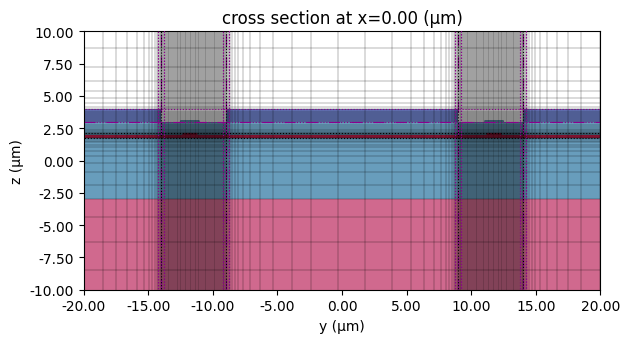

In [9]:
# Visualize the mesh
ax = mzm_solver.plot()
mzm_solver.plot_grid(ax=ax)
center = mzm_solver.simulation.structures[0].geometry.center
ax.set_xlim(center[0] - 20, center[0] + 20)
ax.set_ylim(center[1] - 10, center[1] + 10)
plt.show()

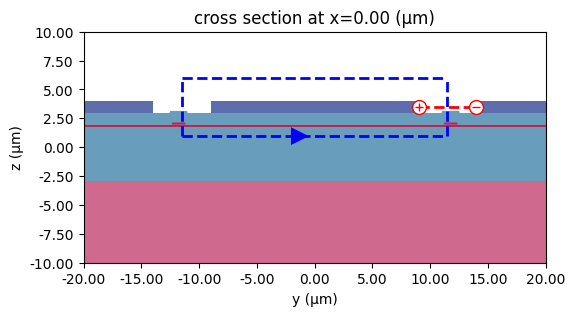

In [10]:
# Plot V and I integration paths
fig, ax = plt.subplots(figsize=(10, 3))
mzm_solver.plot(ax=ax)
I_int.plot(x=0, ax=ax)
V_int.plot(x=0, ax=ax)
ax.set_xlim(-20, 20)
ax.set_ylim(-10, 10)
plt.show()

### Simulation Definition

Now, we define a function to can create the [Simulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html) and [ModeSolver](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.mode.ModeSolver.html) objects.

Since the RF wavelength is much larger than the geometric features, we use a [LayerRefinementSpec](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.LayerRefinementSpec.html) at the CPW to automatically enhance the mesh and better resolve its corners.

For the rest of the simulation, we use the automatic grid with `min_steps_per_sim_size = 100`, which ensures at least 100 grid cells along the longest dimension of the simulation domain.

We will also add mesh override regions to properly resolve the thickness of the optical waveguide, as well as the gaps, to ensure accurate results.

For impedance calculation, we define a [current](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/microwave/_autosummary/tidy3d.plugins.microwave.AxisAlignedCurrentIntegral.html) integration path around the CPW signal, and a [voltage](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/microwave/_autosummary/tidy3d.plugins.microwave.AxisAlignedVoltageIntegral.html) integration path from the signal to ground.

In [11]:
mzm_mode_data = web.run(mzm_solver, task_name="MZM mode solver", path="data/MZM_mode_data.hdf5")

15:09:43 EST Created task 'MZM mode solver' with resource_id                    
             'mo-25e66852-c762-4ea5-b522-e33aec584e4c' and task_type            
             'MODE_SOLVER'.

             View task using web UI at                                          
             ]8;id=694653;https://tidy3d.simulation.cloud/workbench?taskId=mo-25e66852-c762-4ea5-b522-e33aec584e4c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=335881;https://tidy3d.simulation.cloud/workbench?taskId=mo-25e66852-c762-4ea5-b522-e33aec584e4c\taskId]8;;\]8;id=694653;https://tidy3d.simulation.cloud/workbench?taskId=mo-25e66852-c762-4ea5-b522-e33aec584e4c\=]8;;\]8;id=458209;https://tidy3d.simulation.cloud/workbench?taskId=mo-25e66852-c762-4ea5-b522-e33aec584e4c\mo]8;;\]8;id=694653;https://tidy3d.simulation.cloud/workbench?taskId=mo-25e66852-c762-4ea5-b522-e33aec584e4c\-25e66852-c762-]8;;\
             ]8;id=694653;https://tidy3d.simulation.cloud/workbench?taskId=mo-25e66852-c762-4ea5-b522-e33aec584e4c\4ea5-b522-e33aec584e4c']8;;\.

             Task folder: ]8;id=364947;https://tidy3d.simulation.cloud/folders/f89aec3e-3357-4624-9c24-096a87582f12\'default']8;;\.

Output()

15:09:53 EST Estimated FlexCredit cost: 0.008. Minimum cost depends on task     
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

15:09:54 EST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

15:10:24 EST starting up solver

             running solver

15:10:30 EST status = success

             View simulation result at                                          
             ]8;id=884927;https://tidy3d.simulation.cloud/workbench?taskId=mo-25e66852-c762-4ea5-b522-e33aec584e4c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=259582;https://tidy3d.simulation.cloud/workbench?taskId=mo-25e66852-c762-4ea5-b522-e33aec584e4c\taskId]8;;\]8;id=884927;https://tidy3d.simulation.cloud/workbench?taskId=mo-25e66852-c762-4ea5-b522-e33aec584e4c\=]8;;\]8;id=630893;https://tidy3d.simulation.cloud/workbench?taskId=mo-25e66852-c762-4ea5-b522-e33aec584e4c\mo]8;;\]8;id=884927;https://tidy3d.simulation.cloud/workbench?taskId=mo-25e66852-c762-4ea5-b522-e33aec584e4c\-25e66852-c762-]8;;\
             ]8;id=884927;https://tidy3d.simulation.cloud/workbench?taskId=mo-25e66852-c762-4ea5-b522-e33aec584e4c\4ea5-b522-e33aec584e4c']8;;\.

Output()

15:10:33 EST Loading simulation from data/MZM_mode_data.hdf5

Visualizing the results:

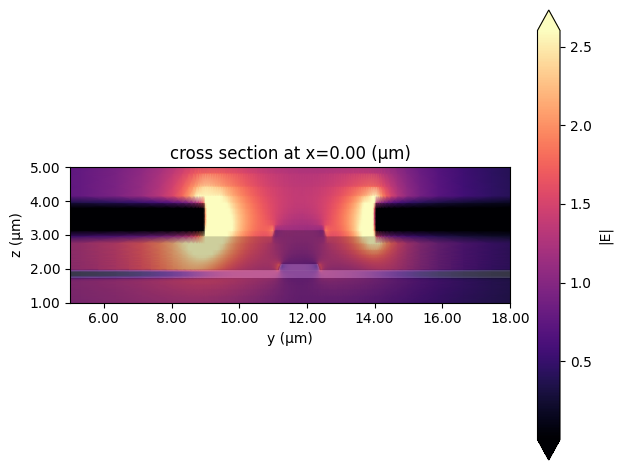

In [12]:
# Visualize the RF mode
ax = mzm_solver.plot_field("E", "abs", f=rf_freqs[0], mode_index=0, robust=True, shading="gouraud")
ax.set_ylim(1, 5)
ax.set_xlim(5, 18)
plt.show()

We can now use the built-in [ImpedanceCalculator](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ImpedanceCalculator.html) to calculate and visualize the impedance results.

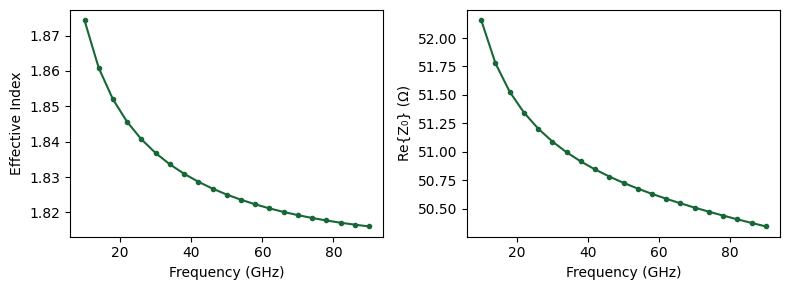

In [13]:
def get_impedance(data, I_int, V_int, plot=True):
    n_eff = data.n_eff.isel(mode_index=0)
    k_eff = data.k_eff.isel(mode_index=0)

    # Calculate Z0
    Z0_mzm = np.conjugate(
        rf.ImpedanceCalculator(voltage_integral=V_int, current_integral=I_int).compute_impedance(
            data
        )
    ).squeeze()

    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True)

        ax[0].plot(rf_freqs * 1e-9, n_eff, ".-")
        ax[0].set(ylabel="Effective Index", xlabel="Frequency (GHz)")

        ax[1].plot(rf_freqs * 1e-9, np.real(Z0_mzm), ".-")
        _ = ax[1].set(ylabel="Re{Z₀} (Ω)", xlabel="Frequency (GHz)")

    return Z0_mzm, n_eff, k_eff


Z0_mzm, n_eff, k_eff = get_impedance(mzm_solver.data, I_int, V_int)


plt.show()

### Sweep Over Different Parameters

Now, we can sweep over different g and w1 parameters, and calculate impedance, effective index and attenuation constant

In [14]:
g_values = np.linspace(2, 16, 10)
w1_values = np.linspace(3, 25, 10)

dict = {}
dic_integrals = {}
for g in g_values:
    for w1 in w1_values:
        sim_vpi, mzm_solver, I_int, V_int = get_sim(
            cpw_gap=g,
            cpw_width=w1,
            h4=2,
            h1=1,
            optical_waveguide_gap=w1 + g / 2,
            fields=["Ey", "Hy", "Hz"],
        )  # Fields for calculating impedance
        dict[f"({g:.2f},{w1:.2f})"] = mzm_solver
        dic_integrals[f"({g:.2f},{w1:.2f})"] = I_int, V_int

batch = web.Batch(simulations=dict, folder_name="mzm_solver")

In [15]:
batch_data = batch.run(path_dir="batch_mzm_solver")

Output()

15:12:12 EST Started working on Batch containing 100 tasks.

15:24:43 EST Maximum FlexCredit cost: 0.895 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after    
             completion.

Output()

15:26:19 EST Batch complete.

15:26:38 EST Loading simulation from                                            
             batch_mzm_solver/mo-5f3a4c62-5f3b-49b3-83f4-c11b4cb70745.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-8996fb52-6fd5-4659-b827-f088f79b0efb.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-b1113f7e-2938-4d06-89ec-f220e86dcf0d.hdf5

15:26:39 EST Loading simulation from                                            
             batch_mzm_solver/mo-1959b6a0-a5ec-4045-a1c9-786204b7d4ae.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-31ac7023-db69-4cce-b4df-fc0675a8a443.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-7d02415a-150e-4fe5-a416-a00afd01c0c4.hdf5

15:26:40 EST Loading simulation from                                            
             batch_mzm_solver/mo-337b5a46-fb06-48d2-ab14-2ae55863b366.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-245709a0-9a56-4253-a6e6-34e4f7976803.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-c3f94b71-a878-49bc-a700-14bb85d723ef.hdf5

15:26:41 EST Loading simulation from                                            
             batch_mzm_solver/mo-9075119b-a1bb-459a-bfab-706b6d41baed.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-f2355ffe-288d-4ccf-9247-cbab9f04ebbd.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-32620ef9-4d0e-4277-8c68-12f65c1838a9.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-305b6a77-75cf-44b9-b3d3-8e77588db942.hdf5

15:26:42 EST Loading simulation from                                            
             batch_mzm_solver/mo-d10ad170-4603-4dc1-8339-a15ac9d01dd6.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-e8632d12-e314-426d-afd7-0d76836c92d4.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-f38f0f2c-4725-4901-ac0b-a1483493c321.hdf5

15:26:43 EST Loading simulation from                                            
             batch_mzm_solver/mo-d9b80b71-a105-42f1-8055-cbd331dbebeb.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-dd59db5a-a7f3-4411-8f63-dabe5e2aa012.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-ac3c5c1a-e3e6-46bf-b74e-6940137e9053.hdf5

15:26:44 EST Loading simulation from                                            
             batch_mzm_solver/mo-c40f8617-f591-41e5-b192-0d2561107293.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-21e26c87-140b-4059-ac68-e8ae2dd4d9ef.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-59453766-d582-4246-b93f-c5b2ce270a0a.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-b804fa2c-cb99-457c-93f0-f5eea92d237f.hdf5

15:26:45 EST Loading simulation from                                            
             batch_mzm_solver/mo-71dd4a1e-4c49-4ea3-bb9f-fc8779e5d6e8.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-0699e765-c4e4-4c7e-8eca-6b6d8aed0e8b.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-d99fb402-ae39-446a-97f5-7b1b5a8166d7.hdf5

15:26:46 EST Loading simulation from                                            
             batch_mzm_solver/mo-ffe7a155-32ea-4e69-9e88-9ae673f8ba2d.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-f4ee6f02-3d1f-430d-8bc7-e1051c545a55.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-def9d049-fcf9-44dc-9b4c-b407283cdf4d.hdf5

15:26:47 EST Loading simulation from                                            
             batch_mzm_solver/mo-31007ea9-b385-45b3-8161-a1f295635d9f.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-3c042c10-3bda-4922-9ef2-0bc322a4dd38.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-0a081e3a-dc62-41cb-bd69-5e5d99da6d86.hdf5

15:26:48 EST Loading simulation from                                            
             batch_mzm_solver/mo-b2f11724-75b7-425e-bb37-d871f12d43b5.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-4f4afc5b-1bfe-4667-ade0-a8e70d700b92.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-48f72b04-208d-46dd-9e24-cd7175df44ad.hdf5

15:26:49 EST Loading simulation from                                            
             batch_mzm_solver/mo-aa0a7482-e6f2-4af8-a36c-67a44cf155e4.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-8d27c2a9-f134-4ae0-bc6d-30e4860fa56d.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-afca8637-ff67-40f2-a151-59788572d929.hdf5

15:26:50 EST Loading simulation from                                            
             batch_mzm_solver/mo-fd7e77fb-b84a-4142-b3fb-0a2059ad8b8d.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-b6c78a1f-de91-41c5-988a-45658bd4dac1.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-30aedb9c-9017-4604-a9a7-997003c89493.hdf5

15:26:51 EST Loading simulation from                                            
             batch_mzm_solver/mo-f4d97453-0578-4875-b791-d1d79b287e6a.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-b2fc54b5-a46f-4646-b517-1fad7ce72fbd.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-8fd28f77-b107-40ea-b109-c51e4c61b83a.hdf5

15:26:52 EST Loading simulation from                                            
             batch_mzm_solver/mo-ee7ee06d-57e0-42e7-bb07-ddcfbdeb133f.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-ebdf7422-77c2-4be5-9b33-8a7bfc93333d.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-a78e9087-95d0-4960-8294-ff865240741b.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-fcaf20af-ae7f-4bb2-8125-a29861531c83.hdf5

15:26:53 EST Loading simulation from                                            
             batch_mzm_solver/mo-2e549ceb-5b38-459f-a981-a10b34782eb6.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-f233c4e5-b477-4e59-8228-7e52aa469e1d.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-db198603-049b-4e88-b558-075b629d1f7f.hdf5

15:26:54 EST Loading simulation from                                            
             batch_mzm_solver/mo-b27a97e9-4c46-4410-a65e-7ba1d97c264e.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-b625fb5e-8436-4b04-a4e1-9006288812e6.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-e74cd13f-6531-4396-b45f-34ecc4923793.hdf5

15:26:55 EST Loading simulation from                                            
             batch_mzm_solver/mo-822dd4cd-0335-4111-932f-00628159b388.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-dc20e093-74e5-437c-ad92-7bbf200a17cd.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-cd2867e8-4600-4466-99a6-204e367d451a.hdf5

15:26:56 EST Loading simulation from                                            
             batch_mzm_solver/mo-fd9a20c5-ce4d-490e-ac24-7f90d321e018.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-3ea1bc34-8bea-4ba5-8a65-56c141dbb37f.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-1ffe632c-6174-4229-86c1-a5ad347fb6ff.hdf5

15:26:57 EST Loading simulation from                                            
             batch_mzm_solver/mo-95188a9f-ac1d-4fad-a088-22a6c715c077.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-455c215e-8d90-415b-a3c6-fab52a93835e.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-9917f672-9c42-4650-b621-2aefd98f04bf.hdf5

15:26:58 EST Loading simulation from                                            
             batch_mzm_solver/mo-e0e1ecc8-59f6-49ed-b4cc-783eceb6a474.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-5d0e4665-7d7c-4cfa-93cd-0a7246349c4e.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-5b8f59bd-aa2c-4d07-a3d7-924af158e236.hdf5

15:26:59 EST Loading simulation from                                            
             batch_mzm_solver/mo-f33b4862-ff5f-4d81-9c45-09a5d679395c.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-8b7885bf-71d7-4f4e-bdbd-7ec139a0b2f7.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-ff06af82-b127-4c22-aac1-50f90868f877.hdf5

15:27:00 EST Loading simulation from                                            
             batch_mzm_solver/mo-7e258be4-67bd-41b3-b567-34a24400da29.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-4fdac554-29cd-4df2-b3b9-f55206ce3ec2.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-bfabdf62-3b4a-45dc-8099-65ce5c9863c9.hdf5

15:27:01 EST Loading simulation from                                            
             batch_mzm_solver/mo-25999a12-cd8f-4aed-9377-8e43460bdc94.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-834dea6b-559e-41b9-a387-d5fbcf689a3b.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-202c2f7f-3c46-49a3-a0fb-9f03a0898c43.hdf5

15:27:02 EST Loading simulation from                                            
             batch_mzm_solver/mo-843a1875-6f01-4796-9eef-cf63658691fe.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-0df16476-468f-41ef-afca-bf3c7440d9dd.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-1429bbb2-8a12-4a78-803f-5db7d325d157.hdf5

15:27:03 EST Loading simulation from                                            
             batch_mzm_solver/mo-053f8c71-6279-4df8-927e-8787d7e7eb27.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-4943e66c-9d75-4cde-97ed-1685cfbfe4c3.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-b602a693-414d-4354-a6b9-65172b18f6bf.hdf5

15:27:04 EST Loading simulation from                                            
             batch_mzm_solver/mo-0a1d8ea4-0571-43a6-a8db-bb39ddfe5078.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-c57a9f72-d149-4ffa-8405-8d0ab25dbbd0.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-02de1f3c-6d10-41e0-8ad4-c20e1333032b.hdf5

15:27:05 EST Loading simulation from                                            
             batch_mzm_solver/mo-4c310f44-3213-446a-95a3-09637f7ec7be.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-15fc7daf-54f0-4ae3-b102-610e32a68af3.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-931cda8e-c338-4489-bab4-745235137d2f.hdf5

15:27:06 EST Loading simulation from                                            
             batch_mzm_solver/mo-d639c8f3-0929-4a33-879e-acfeed51b787.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-1c90cb08-4277-449c-aff8-e74f836508c3.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-6a06afda-3f9e-49ce-9fe8-8af590780635.hdf5

15:27:07 EST Loading simulation from                                            
             batch_mzm_solver/mo-54cc5425-fe49-40ad-8e43-f23d0c6363c7.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-d157dbde-9992-4532-afb1-741e46579bd2.hdf5

15:27:08 EST Loading simulation from                                            
             batch_mzm_solver/mo-9fb7ca96-77ac-45c0-8a37-4ccf58d25a77.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-b5ab2bc4-2ad6-4be0-a0fe-3c61dbb7983d.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-597eb049-5df8-4894-8cb4-ac842982f50c.hdf5

15:27:09 EST Loading simulation from                                            
             batch_mzm_solver/mo-805c7314-7b1c-45ad-844a-b102c566b8e2.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-af3e69ef-b4ab-43f0-b13a-ee65ee9bd26e.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-68eb1d29-0628-48b7-ae43-89ddbcad841f.hdf5

15:27:10 EST Loading simulation from                                            
             batch_mzm_solver/mo-0888a856-774f-477d-8c1e-b8fb8a30dbee.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-b2ffc4ef-bc9f-45c5-979e-804ac8335435.hdf5

### Data Processing

Now we can calculate impedance, RF effective index, RF losses, and reproduce Figures 4a, 4b, and 4c from the reference [paper](https://pubs.acs.org/doi/10.1021/acsomega.3c00310).

In [16]:
import pandas as pd

df_z0 = pd.DataFrame()
df_z0.index.name = "h1"
df_z0.columns.name = "cpw_thickness"

df_neff = pd.DataFrame()
df_neff.index.name = "h1"
df_neff.columns.name = "cpw_thickness"

df_k_eff = pd.DataFrame()
df_k_eff.index.name = "h1"
df_k_eff.columns.name = "cpw_thickness"

for task_name, sim_data in batch_data.items():
    I_int, V_int = dic_integrals[task_name]
    Z0_mzm, n_eff, k_eff = get_impedance(sim_data, I_int, V_int, plot=False)

    h1, cpw_thickness = eval(task_name)
    df_z0.loc[h1, cpw_thickness] = Z0_mzm.sel(f=70e9, method="nearest").values
    df_neff.loc[h1, cpw_thickness] = n_eff.sel(f=70e9, method="nearest").values
    df_k_eff.loc[h1, cpw_thickness] = k_eff.sel(f=70e9, method="nearest").values

15:27:11 EST Loading simulation from                                            
             batch_mzm_solver/mo-5f3a4c62-5f3b-49b3-83f4-c11b4cb70745.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-8996fb52-6fd5-4659-b827-f088f79b0efb.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-b1113f7e-2938-4d06-89ec-f220e86dcf0d.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-1959b6a0-a5ec-4045-a1c9-786204b7d4ae.hdf5

15:27:12 EST Loading simulation from                                            
             batch_mzm_solver/mo-31ac7023-db69-4cce-b4df-fc0675a8a443.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-7d02415a-150e-4fe5-a416-a00afd01c0c4.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-337b5a46-fb06-48d2-ab14-2ae55863b366.hdf5

15:27:13 EST Loading simulation from                                            
             batch_mzm_solver/mo-245709a0-9a56-4253-a6e6-34e4f7976803.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-c3f94b71-a878-49bc-a700-14bb85d723ef.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-9075119b-a1bb-459a-bfab-706b6d41baed.hdf5

15:27:14 EST Loading simulation from                                            
             batch_mzm_solver/mo-f2355ffe-288d-4ccf-9247-cbab9f04ebbd.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-32620ef9-4d0e-4277-8c68-12f65c1838a9.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-305b6a77-75cf-44b9-b3d3-8e77588db942.hdf5

15:27:15 EST Loading simulation from                                            
             batch_mzm_solver/mo-d10ad170-4603-4dc1-8339-a15ac9d01dd6.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-e8632d12-e314-426d-afd7-0d76836c92d4.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-f38f0f2c-4725-4901-ac0b-a1483493c321.hdf5

15:27:16 EST Loading simulation from                                            
             batch_mzm_solver/mo-d9b80b71-a105-42f1-8055-cbd331dbebeb.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-dd59db5a-a7f3-4411-8f63-dabe5e2aa012.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-ac3c5c1a-e3e6-46bf-b74e-6940137e9053.hdf5

15:27:17 EST Loading simulation from                                            
             batch_mzm_solver/mo-c40f8617-f591-41e5-b192-0d2561107293.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-21e26c87-140b-4059-ac68-e8ae2dd4d9ef.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-59453766-d582-4246-b93f-c5b2ce270a0a.hdf5

15:27:18 EST Loading simulation from                                            
             batch_mzm_solver/mo-b804fa2c-cb99-457c-93f0-f5eea92d237f.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-71dd4a1e-4c49-4ea3-bb9f-fc8779e5d6e8.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-0699e765-c4e4-4c7e-8eca-6b6d8aed0e8b.hdf5

15:27:19 EST Loading simulation from                                            
             batch_mzm_solver/mo-d99fb402-ae39-446a-97f5-7b1b5a8166d7.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-ffe7a155-32ea-4e69-9e88-9ae673f8ba2d.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-f4ee6f02-3d1f-430d-8bc7-e1051c545a55.hdf5

15:27:20 EST Loading simulation from                                            
             batch_mzm_solver/mo-def9d049-fcf9-44dc-9b4c-b407283cdf4d.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-31007ea9-b385-45b3-8161-a1f295635d9f.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-3c042c10-3bda-4922-9ef2-0bc322a4dd38.hdf5

15:27:21 EST Loading simulation from                                            
             batch_mzm_solver/mo-0a081e3a-dc62-41cb-bd69-5e5d99da6d86.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-b2f11724-75b7-425e-bb37-d871f12d43b5.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-4f4afc5b-1bfe-4667-ade0-a8e70d700b92.hdf5

15:27:22 EST Loading simulation from                                            
             batch_mzm_solver/mo-48f72b04-208d-46dd-9e24-cd7175df44ad.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-aa0a7482-e6f2-4af8-a36c-67a44cf155e4.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-8d27c2a9-f134-4ae0-bc6d-30e4860fa56d.hdf5

15:27:23 EST Loading simulation from                                            
             batch_mzm_solver/mo-afca8637-ff67-40f2-a151-59788572d929.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-fd7e77fb-b84a-4142-b3fb-0a2059ad8b8d.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-b6c78a1f-de91-41c5-988a-45658bd4dac1.hdf5

15:27:24 EST Loading simulation from                                            
             batch_mzm_solver/mo-30aedb9c-9017-4604-a9a7-997003c89493.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-f4d97453-0578-4875-b791-d1d79b287e6a.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-b2fc54b5-a46f-4646-b517-1fad7ce72fbd.hdf5

15:27:25 EST Loading simulation from                                            
             batch_mzm_solver/mo-8fd28f77-b107-40ea-b109-c51e4c61b83a.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-ee7ee06d-57e0-42e7-bb07-ddcfbdeb133f.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-ebdf7422-77c2-4be5-9b33-8a7bfc93333d.hdf5

15:27:26 EST Loading simulation from                                            
             batch_mzm_solver/mo-a78e9087-95d0-4960-8294-ff865240741b.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-fcaf20af-ae7f-4bb2-8125-a29861531c83.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-2e549ceb-5b38-459f-a981-a10b34782eb6.hdf5

15:27:27 EST Loading simulation from                                            
             batch_mzm_solver/mo-f233c4e5-b477-4e59-8228-7e52aa469e1d.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-db198603-049b-4e88-b558-075b629d1f7f.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-b27a97e9-4c46-4410-a65e-7ba1d97c264e.hdf5

15:27:28 EST Loading simulation from                                            
             batch_mzm_solver/mo-b625fb5e-8436-4b04-a4e1-9006288812e6.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-e74cd13f-6531-4396-b45f-34ecc4923793.hdf5

15:27:29 EST Loading simulation from                                            
             batch_mzm_solver/mo-822dd4cd-0335-4111-932f-00628159b388.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-dc20e093-74e5-437c-ad92-7bbf200a17cd.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-cd2867e8-4600-4466-99a6-204e367d451a.hdf5

15:27:30 EST Loading simulation from                                            
             batch_mzm_solver/mo-fd9a20c5-ce4d-490e-ac24-7f90d321e018.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-3ea1bc34-8bea-4ba5-8a65-56c141dbb37f.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-1ffe632c-6174-4229-86c1-a5ad347fb6ff.hdf5

15:27:31 EST Loading simulation from                                            
             batch_mzm_solver/mo-95188a9f-ac1d-4fad-a088-22a6c715c077.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-455c215e-8d90-415b-a3c6-fab52a93835e.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-9917f672-9c42-4650-b621-2aefd98f04bf.hdf5

15:27:32 EST Loading simulation from                                            
             batch_mzm_solver/mo-e0e1ecc8-59f6-49ed-b4cc-783eceb6a474.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-5d0e4665-7d7c-4cfa-93cd-0a7246349c4e.hdf5

15:27:33 EST Loading simulation from                                            
             batch_mzm_solver/mo-5b8f59bd-aa2c-4d07-a3d7-924af158e236.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-f33b4862-ff5f-4d81-9c45-09a5d679395c.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-8b7885bf-71d7-4f4e-bdbd-7ec139a0b2f7.hdf5

15:27:34 EST Loading simulation from                                            
             batch_mzm_solver/mo-ff06af82-b127-4c22-aac1-50f90868f877.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-7e258be4-67bd-41b3-b567-34a24400da29.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-4fdac554-29cd-4df2-b3b9-f55206ce3ec2.hdf5

15:27:35 EST Loading simulation from                                            
             batch_mzm_solver/mo-bfabdf62-3b4a-45dc-8099-65ce5c9863c9.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-25999a12-cd8f-4aed-9377-8e43460bdc94.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-834dea6b-559e-41b9-a387-d5fbcf689a3b.hdf5

15:27:36 EST Loading simulation from                                            
             batch_mzm_solver/mo-202c2f7f-3c46-49a3-a0fb-9f03a0898c43.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-843a1875-6f01-4796-9eef-cf63658691fe.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-0df16476-468f-41ef-afca-bf3c7440d9dd.hdf5

15:27:37 EST Loading simulation from                                            
             batch_mzm_solver/mo-1429bbb2-8a12-4a78-803f-5db7d325d157.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-053f8c71-6279-4df8-927e-8787d7e7eb27.hdf5

15:27:38 EST Loading simulation from                                            
             batch_mzm_solver/mo-4943e66c-9d75-4cde-97ed-1685cfbfe4c3.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-b602a693-414d-4354-a6b9-65172b18f6bf.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-0a1d8ea4-0571-43a6-a8db-bb39ddfe5078.hdf5

15:27:39 EST Loading simulation from                                            
             batch_mzm_solver/mo-c57a9f72-d149-4ffa-8405-8d0ab25dbbd0.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-02de1f3c-6d10-41e0-8ad4-c20e1333032b.hdf5

15:27:40 EST Loading simulation from                                            
             batch_mzm_solver/mo-4c310f44-3213-446a-95a3-09637f7ec7be.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-15fc7daf-54f0-4ae3-b102-610e32a68af3.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-931cda8e-c338-4489-bab4-745235137d2f.hdf5

15:27:41 EST Loading simulation from                                            
             batch_mzm_solver/mo-d639c8f3-0929-4a33-879e-acfeed51b787.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-1c90cb08-4277-449c-aff8-e74f836508c3.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-6a06afda-3f9e-49ce-9fe8-8af590780635.hdf5

15:27:42 EST Loading simulation from                                            
             batch_mzm_solver/mo-54cc5425-fe49-40ad-8e43-f23d0c6363c7.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-d157dbde-9992-4532-afb1-741e46579bd2.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-9fb7ca96-77ac-45c0-8a37-4ccf58d25a77.hdf5

15:27:43 EST Loading simulation from                                            
             batch_mzm_solver/mo-b5ab2bc4-2ad6-4be0-a0fe-3c61dbb7983d.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-597eb049-5df8-4894-8cb4-ac842982f50c.hdf5

15:27:44 EST Loading simulation from                                            
             batch_mzm_solver/mo-805c7314-7b1c-45ad-844a-b102c566b8e2.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-af3e69ef-b4ab-43f0-b13a-ee65ee9bd26e.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-68eb1d29-0628-48b7-ae43-89ddbcad841f.hdf5

15:27:45 EST Loading simulation from                                            
             batch_mzm_solver/mo-0888a856-774f-477d-8c1e-b8fb8a30dbee.hdf5

             Loading simulation from                                            
             batch_mzm_solver/mo-b2ffc4ef-bc9f-45c5-979e-804ac8335435.hdf5

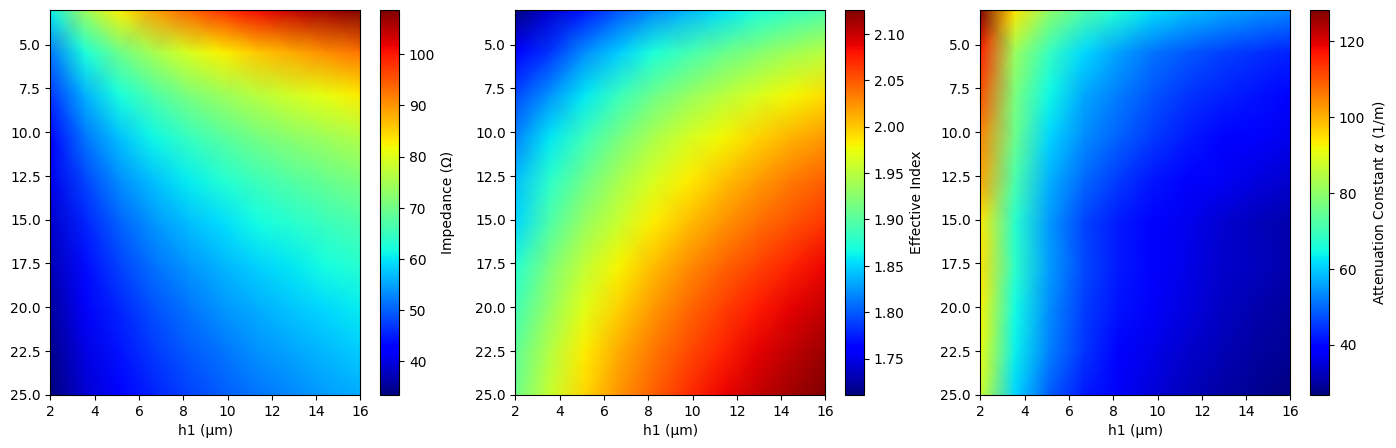

In [17]:
fig, Ax = plt.subplots(ncols=3, figsize=(17, 5))

pm1 = Ax[0].pcolormesh(
    df_z0.index, df_z0.columns, df_z0.values.T.real, cmap="jet", shading="gouraud"
)
cb1 = plt.colorbar(pm1)
cb1.set_label("Impedance (Ω)")

pm2 = Ax[1].pcolormesh(
    df_neff.index, df_neff.columns, df_neff.values.T, cmap="jet", shading="gouraud"
)
cb2 = plt.colorbar(pm2)
cb2.set_label("Effective Index")

df_alpha = 2 * np.pi * (70e9 / td.C_0) * df_k_eff * 10**6
pm3 = Ax[2].pcolormesh(
    df_alpha.index, df_alpha.columns, df_alpha.values.T, cmap="jet", shading="gouraud"
)
cb3 = plt.colorbar(pm3)
cb3.set_label("Attenuation Constant $\\alpha$ (1/m)")

for ax in Ax:
    ax.set_ylim(Ax[2].get_ylim()[::-1])
    ax.set_xlabel("h1 (µm)")

plt.show()

## Computation of Vπ·L <a name="3"></a>

Now we can use the RF fields to calculate the Pockels effect and Vπ·L.

First, we create a final simulation with the optimized parameters, as reported in the reference [paper](https://pubs.acs.org/doi/10.1021/acsomega.3c00310).

In [18]:
cpw_width = 18
cpw_gap = 5
cpw_thickness = 1
h1 = 0.5
optical_waveguide_gap = 25

sim_final, mzm_solver_final, I_int_final, V_int_final = get_sim(
    h4=4.7,  # top SiO2 cladding thickness (µm)
    h2=0.4,
    h1=h1,  # lower layer thickness beneath the electrodes (µm)
    cpw_thickness=cpw_thickness,  # CPW geometry parameters (t)
    cpw_width=cpw_width,  # w1
    cpw_gap=cpw_gap,
    optical_waveguide_gap=optical_waveguide_gap,
    refinement=20,
    resolution=60,
)  # g

mzm_solver_final_data = web.run(
    mzm_solver_final, task_name="MZM mode solver", path="data/MZM_mode_data.hdf5"
)

15:27:46 EST Created task 'MZM mode solver' with resource_id                    
             'mo-ef231e09-d7d9-485c-a560-7af64b5b12bb' and task_type            
             'MODE_SOLVER'.

             View task using web UI at                                          
             ]8;id=877983;https://tidy3d.simulation.cloud/workbench?taskId=mo-ef231e09-d7d9-485c-a560-7af64b5b12bb\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=195993;https://tidy3d.simulation.cloud/workbench?taskId=mo-ef231e09-d7d9-485c-a560-7af64b5b12bb\taskId]8;;\]8;id=877983;https://tidy3d.simulation.cloud/workbench?taskId=mo-ef231e09-d7d9-485c-a560-7af64b5b12bb\=]8;;\]8;id=40860;https://tidy3d.simulation.cloud/workbench?taskId=mo-ef231e09-d7d9-485c-a560-7af64b5b12bb\mo]8;;\]8;id=877983;https://tidy3d.simulation.cloud/workbench?taskId=mo-ef231e09-d7d9-485c-a560-7af64b5b12bb\-ef231e09-d7d9-]8;;\
             ]8;id=877983;https://tidy3d.simulation.cloud/workbench?taskId=mo-ef231e09-d7d9-485c-a560-7af64b5b12bb\485c-a560-7af64b5b12bb']8;;\.

             Task folder: ]8;id=578262;https://tidy3d.simulation.cloud/folders/f89aec3e-3357-4624-9c24-096a87582f12\'default']8;;\.

Output()

15:27:56 EST Estimated FlexCredit cost: 0.009. Minimum cost depends on task     
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

             status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

15:30:20 EST starting up solver

             running solver

15:30:38 EST status = success

             View simulation result at                                          
             ]8;id=473453;https://tidy3d.simulation.cloud/workbench?taskId=mo-ef231e09-d7d9-485c-a560-7af64b5b12bb\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=560637;https://tidy3d.simulation.cloud/workbench?taskId=mo-ef231e09-d7d9-485c-a560-7af64b5b12bb\taskId]8;;\]8;id=473453;https://tidy3d.simulation.cloud/workbench?taskId=mo-ef231e09-d7d9-485c-a560-7af64b5b12bb\=]8;;\]8;id=245164;https://tidy3d.simulation.cloud/workbench?taskId=mo-ef231e09-d7d9-485c-a560-7af64b5b12bb\mo]8;;\]8;id=473453;https://tidy3d.simulation.cloud/workbench?taskId=mo-ef231e09-d7d9-485c-a560-7af64b5b12bb\-ef231e09-d7d9-]8;;\
             ]8;id=473453;https://tidy3d.simulation.cloud/workbench?taskId=mo-ef231e09-d7d9-485c-a560-7af64b5b12bb\485c-a560-7af64b5b12bb']8;;\.

Output()

15:30:43 EST Loading simulation from data/MZM_mode_data.hdf5

To calculate the Pockels effect, we apply an electric field along the LiNbO₃ cut direction to perturb the optical medium. First, we normalize the field by the applied voltage on the push-pull configuration.

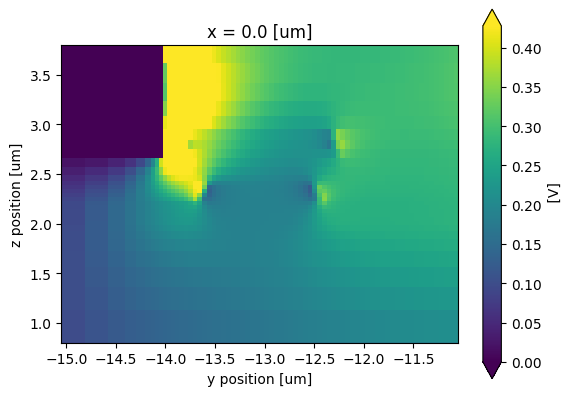

In [19]:
# Compute voltage across the gap and normalize electric field
v0 = V_int_final.compute_voltage(mzm_solver_final_data)
ey_norm = (mzm_solver_final_data.Ey / (0.5 * v0.real)).isel(f=0, mode_index=0, drop=True).abs


waveguide_center = sim_final.structures[8].geometry.bounding_box.center

ax = ey_norm.isel(x=0).transpose("z", "y").plot(robust=True).axes
ax.set_xlim(waveguide_center[1] - 2, waveguide_center[1] + 2)
ax.set_ylim(waveguide_center[2] - 1.5, waveguide_center[2] + 1.5)
ax.set_aspect("equal")
plt.show()

The normalized electric field is applied to the LiNbO₃ crystal along its z-axis, following the Pockels effect model:


$$ \Delta_n = -0.5 n_e^3 r_{33} E $$


Where:
- $\Delta_n$: Index variation
- $n_e$: Extraordinary refractive index
- $r_{33}$: Pockels coefficient (30.9 pm/V) 
- $E$: Normalized electric field from CPW (1V across gap)

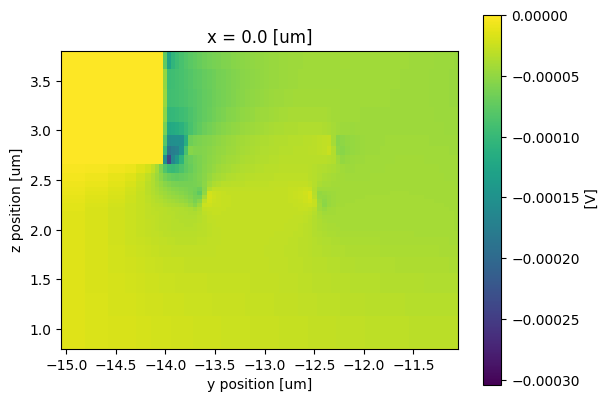

In [20]:
# Extract LiNbO3 material properties at optical wavelength
eps_o, eps_e, _ = (e.real for e in LiNbO3.eps_diagonal(td.C_0 / opt_wavelength))
n_e = eps_e**0.5
r33 = 30.9e-6  # Pockels coefficient in μm/V

# Calculate refractive index variation from Pockels effect
Δn = -0.5 * n_e**3 * r33 * ey_norm

# Plot index variation (perturbation will only take effect over the LiNbO₃ regions)
ax = Δn.isel(x=0).transpose("z", "y").plot(robust=False).axes

ax.set_xlim(waveguide_center[1] - 2, waveguide_center[1] + 2)
ax.set_ylim(waveguide_center[2] - 1.5, waveguide_center[2] + 1.5)

ax.set_aspect("equal")

plt.show()

Now, assuming that the field scales with the applied voltage, we can define an auxiliary function to create the perturbed medium using a [CustomAnisotropicMedium](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.CustomAnisotropicMedium.html) object as a function of the voltage. 

This incorporates the index change due to the RF fields and returns a [ModeSolver](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.mode.ModeSolver.html) object.

In [21]:
# Use a single data point for the homogeneous directions
eps_o_array = td.SpatialDataArray(np.full((1, 1, 1), eps_o), coords={"x": [0], "y": [0], "z": [0]})


def perturbed_solver(voltage):
    perturbed_ln = td.CustomAnisotropicMedium(
        xx=td.CustomMedium(permittivity=eps_o_array, subpixel=True),
        yy=td.CustomMedium(permittivity=(n_e + voltage * Δn) ** 2, subpixel=True),
        zz=td.CustomMedium(permittivity=eps_o_array, subpixel=True),
    )

    # Changing the RF mediums to optical mediums
    si02_structures_index = [0, 9, 12]
    ln_structures_index = [7, 8, 10, 11]

    perturbed_structures = list(sim_final.structures)
    for i in si02_structures_index:
        perturbed_structures[i] = sim_final.structures[i].updated_copy(medium=SiO2)
    for i in ln_structures_index:
        perturbed_structures[i] = sim_final.structures[i].updated_copy(medium=perturbed_ln)

    # Remove metals
    del perturbed_structures[2:5]

    center = waveguide_center
    size = (0, 8, 3)

    perturbed_sim = sim_final.updated_copy(
        structures=perturbed_structures, size=size, center=center, grid_spec=sim_opt.grid_spec
    )

    ms = mode_solver_opt.updated_copy(
        simulation=perturbed_sim, plane=td.Box(size=size, center=center)
    )
    return ms

Next, we create a [Batch](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.web.api.container.Batch.html) and run all mode simulations in parallel.

In [22]:
# Define voltages to apply and create a Batch of simulations
voltages = np.arange(5)
sims = {str(v): perturbed_solver(v) for v in voltages}

batch = web.Batch(simulations=sims, folder_name="perturbed_mode")

We can now visualize the index change for 4V bias.

Output()

Output()

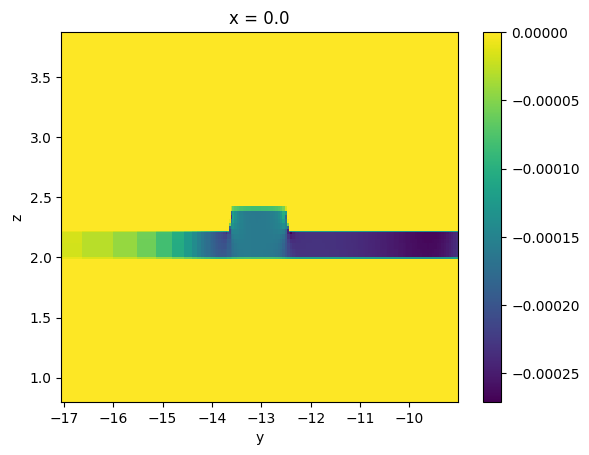

In [23]:
eps0 = sims["0"].simulation.epsilon(sims["0"].plane)
eps4 = sims["4"].simulation.epsilon(sims["4"].plane)

delta_eps = eps4 - eps0
delta_eps.T.real.plot()
plt.show()

In [24]:
# Run all simulations in parallel
batch_data = batch.run(path_dir="batch_perturbed_mode")

Output()

15:31:04 EST Started working on Batch containing 5 tasks.

15:31:42 EST Maximum FlexCredit cost: 0.023 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after    
             completion.

Output()

15:32:03 EST Batch complete.

15:32:04 EST Loading simulation from                                            
             batch_perturbed_mode/mo-512d5306-c0c5-4968-acbd-8d346b2ad238.hdf5

             Loading simulation from                                            
             batch_perturbed_mode/mo-3530ad8b-d91a-431d-84a7-53fc67020c9e.hdf5

15:32:05 EST Loading simulation from                                            
             batch_perturbed_mode/mo-e85a38cd-6646-433d-95c2-6f91c98a6362.hdf5

             Loading simulation from                                            
             batch_perturbed_mode/mo-b0b3be74-39a8-4009-ba71-ebb5e081a822.hdf5

             Loading simulation from                                            
             batch_perturbed_mode/mo-3f6d5773-368d-4f81-b572-b6d8c6a0482c.hdf5

Finally, we can observe the variation of the waveguide mode effective index as a function of the applied voltage and calculate the Vπ·L figure of merit.

15:32:06 EST Loading simulation from                                            
             batch_perturbed_mode/mo-512d5306-c0c5-4968-acbd-8d346b2ad238.hdf5

             Loading simulation from                                            
             batch_perturbed_mode/mo-3530ad8b-d91a-431d-84a7-53fc67020c9e.hdf5

             Loading simulation from                                            
             batch_perturbed_mode/mo-e85a38cd-6646-433d-95c2-6f91c98a6362.hdf5

15:32:07 EST Loading simulation from                                            
             batch_perturbed_mode/mo-b0b3be74-39a8-4009-ba71-ebb5e081a822.hdf5

             Loading simulation from                                            
             batch_perturbed_mode/mo-3f6d5773-368d-4f81-b572-b6d8c6a0482c.hdf5

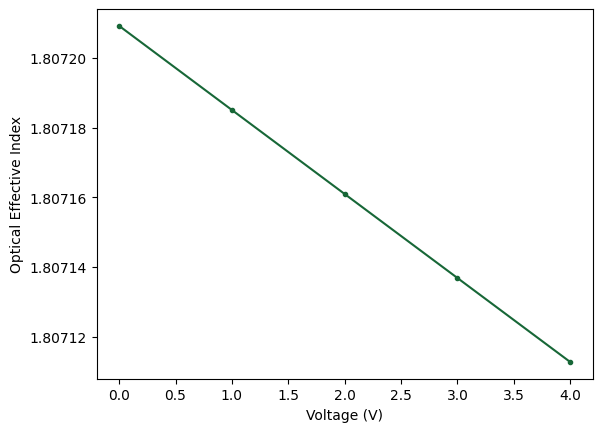

In [25]:
n_eff = [sim_data.n_eff.isel(mode_index=0, f=0).item() for sim_data in batch_data.values()]

_ = plt.plot(voltages, n_eff, ".-")
_ = plt.ticklabel_format(style="plain", useOffset=False)
plt.gca().set(xlabel="Voltage (V)", ylabel="Optical Effective Index")

plt.show()

In [26]:
# The variation is quite linear, so we simply use the largest interval
dneff_dV = abs(n_eff[-1] - n_eff[0]) / (voltages[-1] - voltages[0])

vpil = 0.5 * opt_wavelength / dneff_dV  # in V·μm"

print(f"Vπ·L (push-pull)    = {vpil * 1e-4 / 2:.2f} V·cm")

Vπ·L (push-pull)    = 1.61 V·cm
